# Project: Analyze A/B Test Results for an Ecommerce.
Fabricio Paez - 2020


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that we get some practice working with the difficulties of these.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Our goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#I will set the seed to assure that the reader can get the same answers
random.seed(42)

<a id='probability'></a>
### Part I - Probability

a. Let's read  the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


b. Let's find the number of rows in the dataset.

In [4]:
# No. of rows in the dataset

df.shape[0]

294478

c. The number of unique users in the dataset:

In [5]:
# No. of unique users in the dataset

df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
round(df.converted.mean(),3)

0.12

e. Do any of the rows have missing values?

In [7]:
#There are no nulls!
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [8]:
# Also there are no duplicated rows
df.duplicated().sum()

0

f. The number of times the new_page and treatment don't match.
>Let's remember that in an AB Testing, Version A might be the currently used version **(control)**, while version B is modified in some respect **(treatment)**

In [9]:
df.groupby('landing_page').group.value_counts().sort_index()

landing_page  group    
new_page      control        1928
              treatment    145311
old_page      control      145274
              treatment      1965
Name: group, dtype: int64

In [10]:
# To have a better view, the frequency table to show the times where new_page and treatment records don't align

pd.crosstab(df.group, df.landing_page, margins=True)

landing_page,new_page,old_page,All
group,,,
control,1928,145274,147202
treatment,145311,1965,147276
All,147239,147239,294478


In [11]:
group1 = len(df.query('group!="treatment" and landing_page=="new_page"'))# number of times when the group is not treatment but langing page is new page
group2 = len(df.query('group!="control" and landing_page=="old_page"'))# number of times when group is not control but langing page is old page
group=group1+group2
group

3893

> **For the rows where treatment does not match with new_page or control does not match with old_page, we cannot be sure if this row truly received the new or old page.** We will do some Data Wrangling work now.

In [12]:
# We will define a new dataframe df2 from df where we excluded the 3893 records where new_page and trement didn't line up

In [13]:
df2 = df[((df['group']=='treatment') & (df['landing_page']=='new_page')) | ((df['group']=='control') & (df['landing_page']=='old_page'))]

In [14]:
#Lets check
pd.crosstab(df2.group, df2.landing_page, margins=True)

landing_page,new_page,old_page,All
group,,,
control,0,145274,145274
treatment,145311,0,145311
All,145311,145274,290585


Using the new Data Frame let's deep more into de data:

a. Unique user_ids are in df2?

In [15]:
# No. of unique user_ids after cleaning our dataset.

df2['user_id'].nunique()

290584

b. There is one user_id repeated in df2. What is it?

In [17]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

In [19]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. Let's remove one of the rows with a duplicate user_id, we will keep our dataframe as df2.

In [20]:
# Drop one of the rows that belongs to the repeated user_id and keep the first record

df2 = df2.drop_duplicates(subset='user_id')

In [21]:
# No. of rows after removing the duplicate 

df2.shape

(290584, 5)

### Probability Exploration

a. What is the probability of an individual converting regardless of the page they receive?

In [22]:
# Probability of an individual converting regardless of the page they receive
round(df2['converted'].mean(),4)

0.1196

b. Given that an individual was in the `control` group, what is the probability they converted?

In [23]:
round(df2.query('group=="control"').converted.mean(),4)

0.1204

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
round(df2.query('group=="treatment"').converted.mean(),4)

0.1188

d. What is the probability that an individual received the new page?

In [25]:
round((df2.landing_page=='new_page').mean(),4)

0.5001

e. Considering the results from parts (a) through (d) above, let's explain below whether there is sufficient evidence to conclude that the new treatment page leads to more conversions.

> Based on the output above, it looks like that the control group has a slightly higher conversion rate (0.1204) than the treatment group (0.1195), however, **these results don't provide a solid evidence** if one page leads to more conversions as we still don't know the significance of these results and the factors that might have contributed to the results above, such as  change aversion/resistence, test time duration or pure chance of the sample. **In order to provide a meaningful information to support the decision whether to implement the new page or keep the old page, we need to define our test hypothesis and calculate p-value for the new and old pages.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be? 


> ${H}$1: $p_{new}$ - **$p_{old}$** > 0

`2.` Let's assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, let's assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

We will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? <br><br>

In [26]:
# As per the instruction above, p_old = p_new = converted rate in ab_data.csv regardless of the page
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [27]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [28]:
# Create a dataframe with all new page records from df2

newPage_df = df2.query('landing_page == "new_page"')
n_new = newPage_df.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the treatment group?

In [29]:
# Create a dataframe with all old page records from df2

oldPage_df = df2.query('landing_page == "old_page"')
n_old = oldPage_df.shape[0]
n_old

145274

e. Let's simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [30]:
new_page_converted=np.random.choice([0,1],n_new,p=[1-p_new,p_new])

f. Let's simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [31]:
old_page_converted=np.random.choice([0,1],n_old,p=[1-p_old,p_old])

g.Let's find $p_{new}$ - $p_{old}$ for our simulated values from part (e) and (f).

In [32]:
diff=new_page_converted.mean()-old_page_converted.mean()
diff

0.00028706506288553313

> We are looking at a null where there is no difference in conversion based on the page, which means the conversions for each page are the same.

h. Let's create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [33]:
# Create sampling distribution for difference in p_new-p_old simulated values
# with boostrapping
p_diffs = []
for i in range(10000):
    
    # To remember: 1st parameter dictates the choices you want.  In this case [1, 0]
    p_new1 = np.random.choice([1, 0],n_new,replace = True,p = [p_new, 1-p_new])
    p_old1 = np.random.choice([1, 0],n_old,replace = True,p = [p_old, 1-p_old])
    p_new2 = p_new1.mean()
    p_old2 = p_old1.mean()
    p_diffs.append(p_new2-p_old2)

i. Plotting a histogram of the p_diffs:

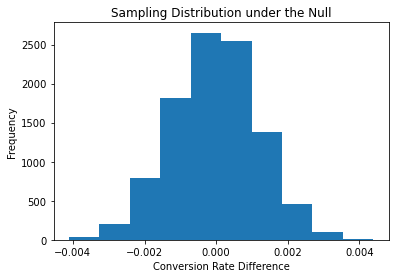

In [34]:
#let's look at our sampling distribution

plt.hist(p_diffs)
plt.title('Sampling Distribution under the Null')
plt.xlabel('Conversion Rate Difference') 
plt.ylabel('Frequency');

In [36]:
# Calculate the actucl difference observed in ab_data
obs_old_mean = df2.query('group =="control"').converted.mean()
obs_new_mean = df2.query('group =="treatment"').converted.mean()
obs_diff = obs_new_mean - obs_old_mean
obs_diff

-0.0015782389853555567

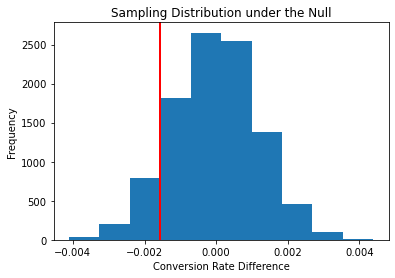

In [37]:
### Plotting the observed difference
plt.hist(p_diffs)
plt.title('Sampling Distribution under the Null')
plt.xlabel('Conversion Rate Difference') 
plt.ylabel('Frequency')
plt.axvline(obs_diff,color='red',linewidth=2);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [38]:
p_diffs=np.array(p_diffs)
(p_diffs>obs_diff).mean()

0.8998

k. Let's explain using the vocabulary we've learned in Udacity nanodegree what we just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>Answer: **Given the p-value of 0.9, we fail to reject the null as no statistical significance is implied between the difference in the conversion rate for the landing pages.**



l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [40]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))

m. Now let's use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [41]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

z_score, p_value

(1.3109241984234394, 0.9050583127590245)

> The alternative hypothesis can be either two-sided or one of the one- sided tests, smaller means that the alternative hypothesis is prop < value and larger means prop > value. In the two sample test, smaller means that the alternative hypothesis is p1 < p2 and larger means p1 > p2 where p1 is the proportion of the first sample and p2 of the second one.

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [43]:
from scipy.stats import norm
norm.cdf(z_score) #how significant our z_score is

0.9050583127590245

In [44]:
norm.ppf(1-(0.05)) #critical value of 95% confidence

1.6448536269514722

> Answer: z_score is less than 1.6448, therefore, we would fail to reject the Null; which is consistent with the results in parts j & k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> **Logistic Regression**

b. The goal is to use statsmodels to fit the regression model you specified in part a. to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received. Add an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.

In [76]:
#adding an intercept column
df2['intercept'] = 1

#Create dummy variable column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [77]:
logit = sm.Logit(df2['converted'],df2[['intercept','ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [78]:
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 29 Aug 2020   Pseudo R-squ.:               8.077e-06
Time:                        11:09:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer**: p-value = -1.311;

$$H_0: p_{new} = p_{old}$$$$H_1: p_{new} \neq p_{old}$$
The difference is, in part II, we performed a one-sided test, where in the logistic regression part, it is two-sided test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> Answer: Considering other factors is a good idea as these factors may contribute to the significance of our test results and leads to more accurate decisions. One of the disadvantages of adding additional terms into the regression model is Simpson's paradox where the combined impact of different variables disappears or reverses when these variables are combined, but appears where these variables are tested individually.

g. Now along with testing if the conversion rate changes for different pages, let's also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [57]:
countries_df = pd.read_csv('countries.csv',index_col='user_id')
countries_df.head()

,country
user_id,
834778,UK
928468,US
822059,UK
711597,UK
710616,UK


In [79]:
new_df=countries_df.merge(df2,on='user_id',how='inner').set_index('user_id')
new_df

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1
...,...,...,...,...,...,...,...
653118,US,2017-01-09 03:12:31.034796,control,old_page,0,1,0
878226,UK,2017-01-05 15:02:50.334962,control,old_page,0,1,0
799368,UK,2017-01-09 18:07:34.253935,control,old_page,0,1,0


In [80]:
new_df['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [81]:
### Create the necessary dummy variables

new_df[['CA', 'US']] = pd.get_dummies(new_df['country'])[['CA','US']]
new_df.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0


h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [82]:
### Fit Your Linear Model And Obtain the Results

log_mod = sm.Logit(new_df['converted'], new_df[['intercept','ab_page','CA', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 29 Aug 2020   Pseudo R-squ.:               2.323e-05
Time:                        11:10:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

Conclusions: None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.

In [83]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0